# Advanced Business Analytics (CIS442D)

## Homework Assignment 5
### Due date: 2/16/2017 23:55
### Submission Instructions
1. Each student should submit an individual homework assignment.
2. Discussing solutions with others is allowed.
3. Copying solutions is prohibited.
4. Late submissions will not be accepted.
5. Write your solutions in Jupyter IPython notebooks. Use markdown cells to format your document. Your solutions should be replicable, as it will be executed on the grader's computer.
6. Solution files should be uploaded to Blackboard.
---

# Exercise 1: simple recommendation system

In this homework assignment, you are asked to construct a recommendation system that predicts movie ratings. 

1. Download the data from http://grouplens.org/datasets/movielens/1m/ (the file README contains information about the structure of each of the datafiles)
2. Plot a histogram of the ratings showing the frequency of ratings across all users (that is, how many votes are for rating 1, ratin 2, etc.)
3. Split the ratings data (ratings.dat) randomly to training and test data (you may use the train_test_split function from scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Use the training data to construct a baseline predictor, which predicts the average movie rating by all users
5. Construct a collaborative filtering predictor
6. Use the training data to measure the prediction accuracy of the two predictors. Explain your choice for the accuracy measure
7. (Bonus) Use the other data available in the file to construct a more accurate predictor. Describe your algorithm and compare its performance with the other predictors. 

In addition to the code, please provide succient description of your algroithms.

In [2]:
!ls


README          movies.dat      users.dat
homework5.ipynb ratings.dat     votes.csv


In [3]:
!head -10 movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [4]:
!head -10 ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


In [5]:
!head -10 users.dat

1::F::1::10::48067
2::M::56::16::70072
3::M::25::15::55117
4::M::45::7::02460
5::M::25::20::55455
6::F::50::9::55117
7::M::35::1::06810
8::M::25::12::11413
9::M::25::17::61614
10::F::35::1::95370


In [6]:
!cat readme

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In [7]:
!wc *.dat

    3883   15675  171308 movies.dat
 1000209 1000209 24594131 ratings.dat
    6040    6040  134368 users.dat
 1010132 1021924 24899807 total


In [2]:
# Read the rating.dat file
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

arr=np.loadtxt('ratings.dat',delimiter='::')
arr[1]

# declare index
index = [i for i in range(1, len(arr)+1)]
# declare column name
column = ['UserID','MovieID','Rating','Timestamp']
df_rating = pd.DataFrame(data=arr[0:,0:],    
             index=index,
             columns = column)


In [5]:
#rating = df_rating["Rating"]
#df_rating["UserID"] = df_rating["UserID"].astype(int)
#df_rating["MovieID"] = df_rating["MovieID"].astype(int)
#df_rating["Rating"] = df_rating["Rating"].astype(int)

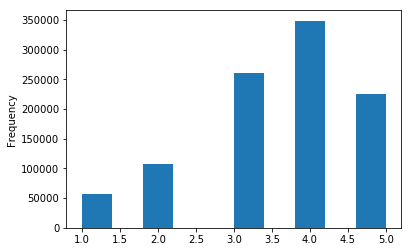

In [6]:
#Plot a histogram of the ratings showing the frequency of ratings across all users 
import matplotlib.pyplot as plt
%matplotlib inline
df_rating["Rating"].plot.hist()

In [69]:
from sklearn.model_selection import train_test_split
# split the data into trainning data and test data
df_train, df_test = train_test_split(df_rating, test_size=0.95)

def base_train(df_train):
    # mean value of rating
    mu = df_train[["Rating"]].mean(axis=0)
    # calculate oberved deviation of movie
    movie_rating = df_train.groupby('MovieID').agg(['mean', 'count','std'])
    bi = ((movie_rating.Rating["mean"]*movie_rating.Rating["count"])-(mu[0]*movie_rating.Rating["count"]))/(25+movie_rating.Rating["count"])
    bi = pd.DataFrame(data = bi, columns = ['bi'])
    df_train = df_train.merge(bi, left_on= "MovieID", right_index=True)
    # calculate oberved deviation of user
    user_rating = df_train.groupby('UserID').agg(['mean', 'count','std'])
    bu = ((user_rating.Rating["mean"]*user_rating.Rating["count"])-(mu[0]*user_rating.Rating["count"])-(user_rating.bi["mean"]*user_rating.bi["count"]))/(10+user_rating.Rating["count"])
    bu = pd.DataFrame(data = bu, columns = ['bu'])
    df_train = df_train.merge(bu, left_on= "UserID", right_index=True)
    # compute the baseline predict result
    df_train['base_predict'] = mu[0] + df_train['bi']+df_train['bu']
    del df_train['bi']
    del df_train['bu']
    
    return df_train['base_predict']


In [70]:
# predict the rating
base_pred = base_train(df_train)

In [71]:
# how many users and movies in the data
n_users = df_rating.UserID.max()
n_items = df_rating.MovieID.max()
print(str(n_users) + ' users')
print(str(n_items) + ' items')

# build a matrix for each user and each movie
ratings = np.zeros((n_users+1, n_items+1))

# the first row is moviesID and first column is userID
# the matrix contain each user rating to each movie
# use the only trainning data
for row in df_train.itertuples():
    ratings[0,row[2]] = row[2]
    ratings[row[1],0] = row[1]
    ratings[row[1], row[2]] = row[3]


6040.0 users
3952.0 items


/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [72]:
# convert it to dataframe and substute 0 value with nan
df = pd.DataFrame(ratings[1:,1:],index=ratings[1:,0],columns = ratings[0,1:])
df[df <= 0] = np.nan
df
# calculate the similarity matrix from the above matrix
user_similarity = df.T.corr()
user_similarity


,1.0,2.0,3.0,0.0,5.0,6.0,7.0,8.0,9.0,10.0,...,6031.0,6032.0,6033.0,6034.0,6035.0,6036.0,6037.0,6038.0,6039.0,6040.0
1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:

def cf_train(df_train):
    #calculate mean for each user
    user_rating = df_train.groupby('UserID').agg(['mean', 'count','std'])
    user_avg = user_rating.Rating["mean"]
    user_avg = pd.DataFrame(data = user_avg)
    df_train = df_train.merge(user_avg, left_on= "UserID", right_index=True)
    df_train['cf_pred'] = 0
    # iterate the trainning data
    for i in range(0,len(df_train)):
        movie = df_train.iloc[i,1]
        user = df_train.iloc[i,0]
        mean1 = df_train.iloc[i,4]
        # find the users who rate the specific movie
        movie_group = df.loc[:,movie]
        movie_group = movie_group.dropna()
        n = 0
        d = 0
        # for each user who rate the movie
        for j in range(0,len(movie_group)):
            # find similarity
            similarity = user_similarity.loc[(movie_group.index[j]),(user)]
            # if no similarity
            if np.isnan(similarity):
                continue
            # if there is similarity
            else:
                mean2 = user_rating.loc[(movie_group.index[j]),'Rating'][0]
                n = n+(movie_group.iloc[j]-mean2)*similarity
                d = d+similarity
        # if no similar user
        if(d != 0):
            df_train.cf_pred.iloc[i] = n/d+mean1
        # if there is similar users
        else:
            df_train.cf_pred.iloc[i] = mean1
            
    return df_train['cf_pred']



In [74]:
# Predict the ratings
cf_pred = cf_train(df_train)


/Users/Qingyuan/Applications/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [75]:
cf_pred

245970    5.000000
245965    3.000000
638195    1.866114
638754    1.640858
637889    6.790360
637893   -4.086048
638631    1.285763
638720    1.361427
638282    4.000000
638025    4.000000
638129    1.977083
637790    5.000000
637740    5.610658
638627    2.098767
638552   -6.416956
638024    3.523438
638034    2.724119
637943    4.059645
638621    3.950980
638315    1.595732
638346    2.254025
638521    6.130562
637804    4.765700
638371    4.848837
638102   -1.868074
638292    1.491266
638651    4.877612
637891    2.192145
638497    1.185970
638030    1.904753
            ...   
978540    4.000000
91540     5.000000
520904    5.000000
481048    5.000000
660248    4.000000
712283    4.000000
274164    5.000000
668003    5.000000
464728    3.000000
464721    3.000000
300993    4.000000
834788    5.000000
425107    3.000000
967857    4.000000
516194    3.000000
828192    4.000000
701607    3.000000
179918    3.000000
701993    4.000000
421726    3.000000
448967    4.000000
266893    5.

In [76]:
# I use the mean squared error. Since we are predicting the ratings, which is not a binary variable, 
# we have to calculate the distance between our predict value and the actual value. So mean squared error is a
# proper metric to measure the accuracy.

from sklearn.metrics import mean_squared_error
print('baseline MSE: '+ str(mean_squared_error(base_pred,df_train['Rating'])))
print('CF MSE: '+ str(mean_squared_error(cf_pred,df_train['Rating'])))

# The difference between the two filter is that we consider about the similarity between users. In baseline MSE, we 
# consider each user equal to the predicting user by using mean. However, for CF, we only consider about the user who
# rate the same movie. This give us more confident about our predicting result.

baseline MSE: 1.42467197875
CF MSE: 7.28257380547e+29


# Exercise 2: PageRank
Based on Chapter 11 in "The analytics edge" by Bertsimas et al. 
Data source: https://www.dynamic-ideas.com/Books/0989910897/anedge.html

The file  "votes.csv" contains the voting preferences of an executive board on the new CEO. Use the PageRank algorithm to rank the candidates according to the votes. You can think about each person as a node, and each vote as an arc from one person to another.
1. After how many iterations did the algorithm converge? explain.
2. Plot a graph representing the voting preferences (who votes for who).
3. Rank the candidates (display the result of PageRank).
4. Rank the candidates based on the total number of votes each candidate received.
5. Explain the differences in the final rankings created by the two methods.

In [3]:
vote = pd.read_csv("votes.csv")
vote


,Members,Vote 1,Vote 2,Vote 3,Vote 4,Vote 5
0,Bill Connors,Tom Schwartz,Martin Williams,NaN,NaN,NaN
1,Mary Little,Robert Garcia,Clark Johnson,Anita Miller,Irene Kim,NaN
2,Tom Schwartz,Robert Garcia,Yvonne Campbell,NaN,NaN,NaN
3,Robert Garcia,Tom Schwartz,Thomas Taylor,Jack Anderson,NaN,NaN
4,Amanda Lynn,Mary Little,Carmen Smith,Martin Williams,Edward Davis,Lilian Reed
5,Carmen Smith,Amanda Lynn,Irene Kim,NaN,NaN,NaN
6,Clark Johnson,Martin Williams,Elaine Robinson,Preston Walker,NaN,NaN
7,Martin Williams,Robert Garcia,Fred Rogers,NaN,NaN,NaN
8,Frank Liu,Fred Rogers,Irene Kim,NaN,NaN,NaN
9,Fred Rogers,Mary Little,Edward Davis,Ginger Wrout,Paul Young,NaN


In [4]:
x = vote.Members.unique().shape[0]
votes = np.zeros((x, x))

tm = pd.DataFrame(votes,index=vote.Members,columns = vote.Members)

tm.loc[vote.iloc[1,1],vote.iloc[1,1]]
for i in range(0,len(vote)):
    count = 5-vote.iloc[i,].isnull().sum()
    for j in range(1,count+1):
        tm.loc[vote.iloc[i,0],vote.iloc[i,j]] = 1/count
        
numpyMatrix = tm.as_matrix()
tm

Members,Bill Connors,Mary Little,Tom Schwartz,Robert Garcia,Amanda Lynn,Carmen Smith,Clark Johnson,Martin Williams,Frank Liu,Fred Rogers,...,Julia Miyagi,John Adams,Maria Roberts,Yvonne Campbell,Collin O'Reilly,George Karev,Lilian Reed,Colleen Murphy,Milton Erickson,Sara Fitzgerald
Members,,,,,,,,,,,,,,,,,,,,,
Bill Connors,0.0,0.00,0.500000,0.00,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Mary Little,0.0,0.00,0.000000,0.25,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Tom Schwartz,0.0,0.00,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.000000
Robert Garcia,0.0,0.00,0.333333,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Amanda Lynn,0.0,0.20,0.000000,0.00,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.000000
Carmen Smith,0.0,0.00,0.000000,0.00,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Clark Johnson,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Martin Williams,0.0,0.00,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
Frank Liu,0.0,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [7]:
T0 = np.ones(x)
result = []
T_i = T0
for i in range(1,50):
    result.append(T_i)
    T_i = np.dot(T_i,tm)
pd.DataFrame(data=result, columns= vote.Members)


Members,Bill Connors,Mary Little,Tom Schwartz,Robert Garcia,Amanda Lynn,Carmen Smith,Clark Johnson,Martin Williams,Frank Liu,Fred Rogers,...,Julia Miyagi,John Adams,Maria Roberts,Yvonne Campbell,Collin O'Reilly,George Karev,Lilian Reed,Colleen Murphy,Milton Erickson,Sara Fitzgerald
0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000
1,0.0,0.650000,2.166667,2.750000,2.666667,1.733333,2.083333,1.366667,1.733333,1.333333,...,0.0,0.750000,0.0,0.900000,0.0,0.500000,0.933333,0.0,0.400000,0.333333
2,0.0,1.033333,2.866667,2.345833,3.230556,1.422222,1.306944,1.294444,2.594444,1.661111,...,0.0,0.587500,0.0,1.350000,0.0,0.466667,1.033333,0.0,0.500000,0.611111
3,0.0,1.183056,2.040278,3.022222,2.815509,1.200556,1.089815,1.215093,2.807870,1.966667,...,0.0,0.368750,0.0,1.648333,0.0,0.516667,0.992778,0.0,0.346667,0.305556
4,0.0,1.183102,2.379213,2.651921,2.740540,1.055972,1.377986,1.010818,3.162809,2.055926,...,0.0,0.337778,0.0,1.251806,0.0,0.496389,1.007546,0.0,0.444444,0.260648
5,0.0,1.182465,2.234529,2.906578,2.550720,1.125040,1.316316,1.121140,3.114158,2.114961,...,0.0,0.341493,0.0,1.409259,0.0,0.503773,0.895256,0.0,0.347148,0.335802
6,0.0,1.157704,2.330509,2.728389,2.614311,1.026081,1.509498,1.031539,3.254093,2.155551,...,0.0,0.339789,0.0,1.336839,0.0,0.447628,0.861034,0.0,0.350890,0.294658
7,0.0,1.180987,2.248348,2.807195,2.539124,1.046261,1.355272,1.109407,3.252015,2.170357,...,0.0,0.343126,0.0,1.374017,0.0,0.430517,0.840634,0.0,0.317772,0.322953
8,0.0,1.169021,2.302205,2.763065,2.582979,1.000957,1.427387,1.035664,3.300585,2.208504,...,0.0,0.347639,0.0,1.328885,0.0,0.420317,0.824275,0.0,0.316450,0.303154
9,0.0,1.189215,2.280162,2.772560,2.525383,1.014713,1.376003,1.069174,3.302838,2.193485,...,0.0,0.349620,0.0,1.355659,0.0,0.412137,0.830140,0.0,0.313544,0.311911


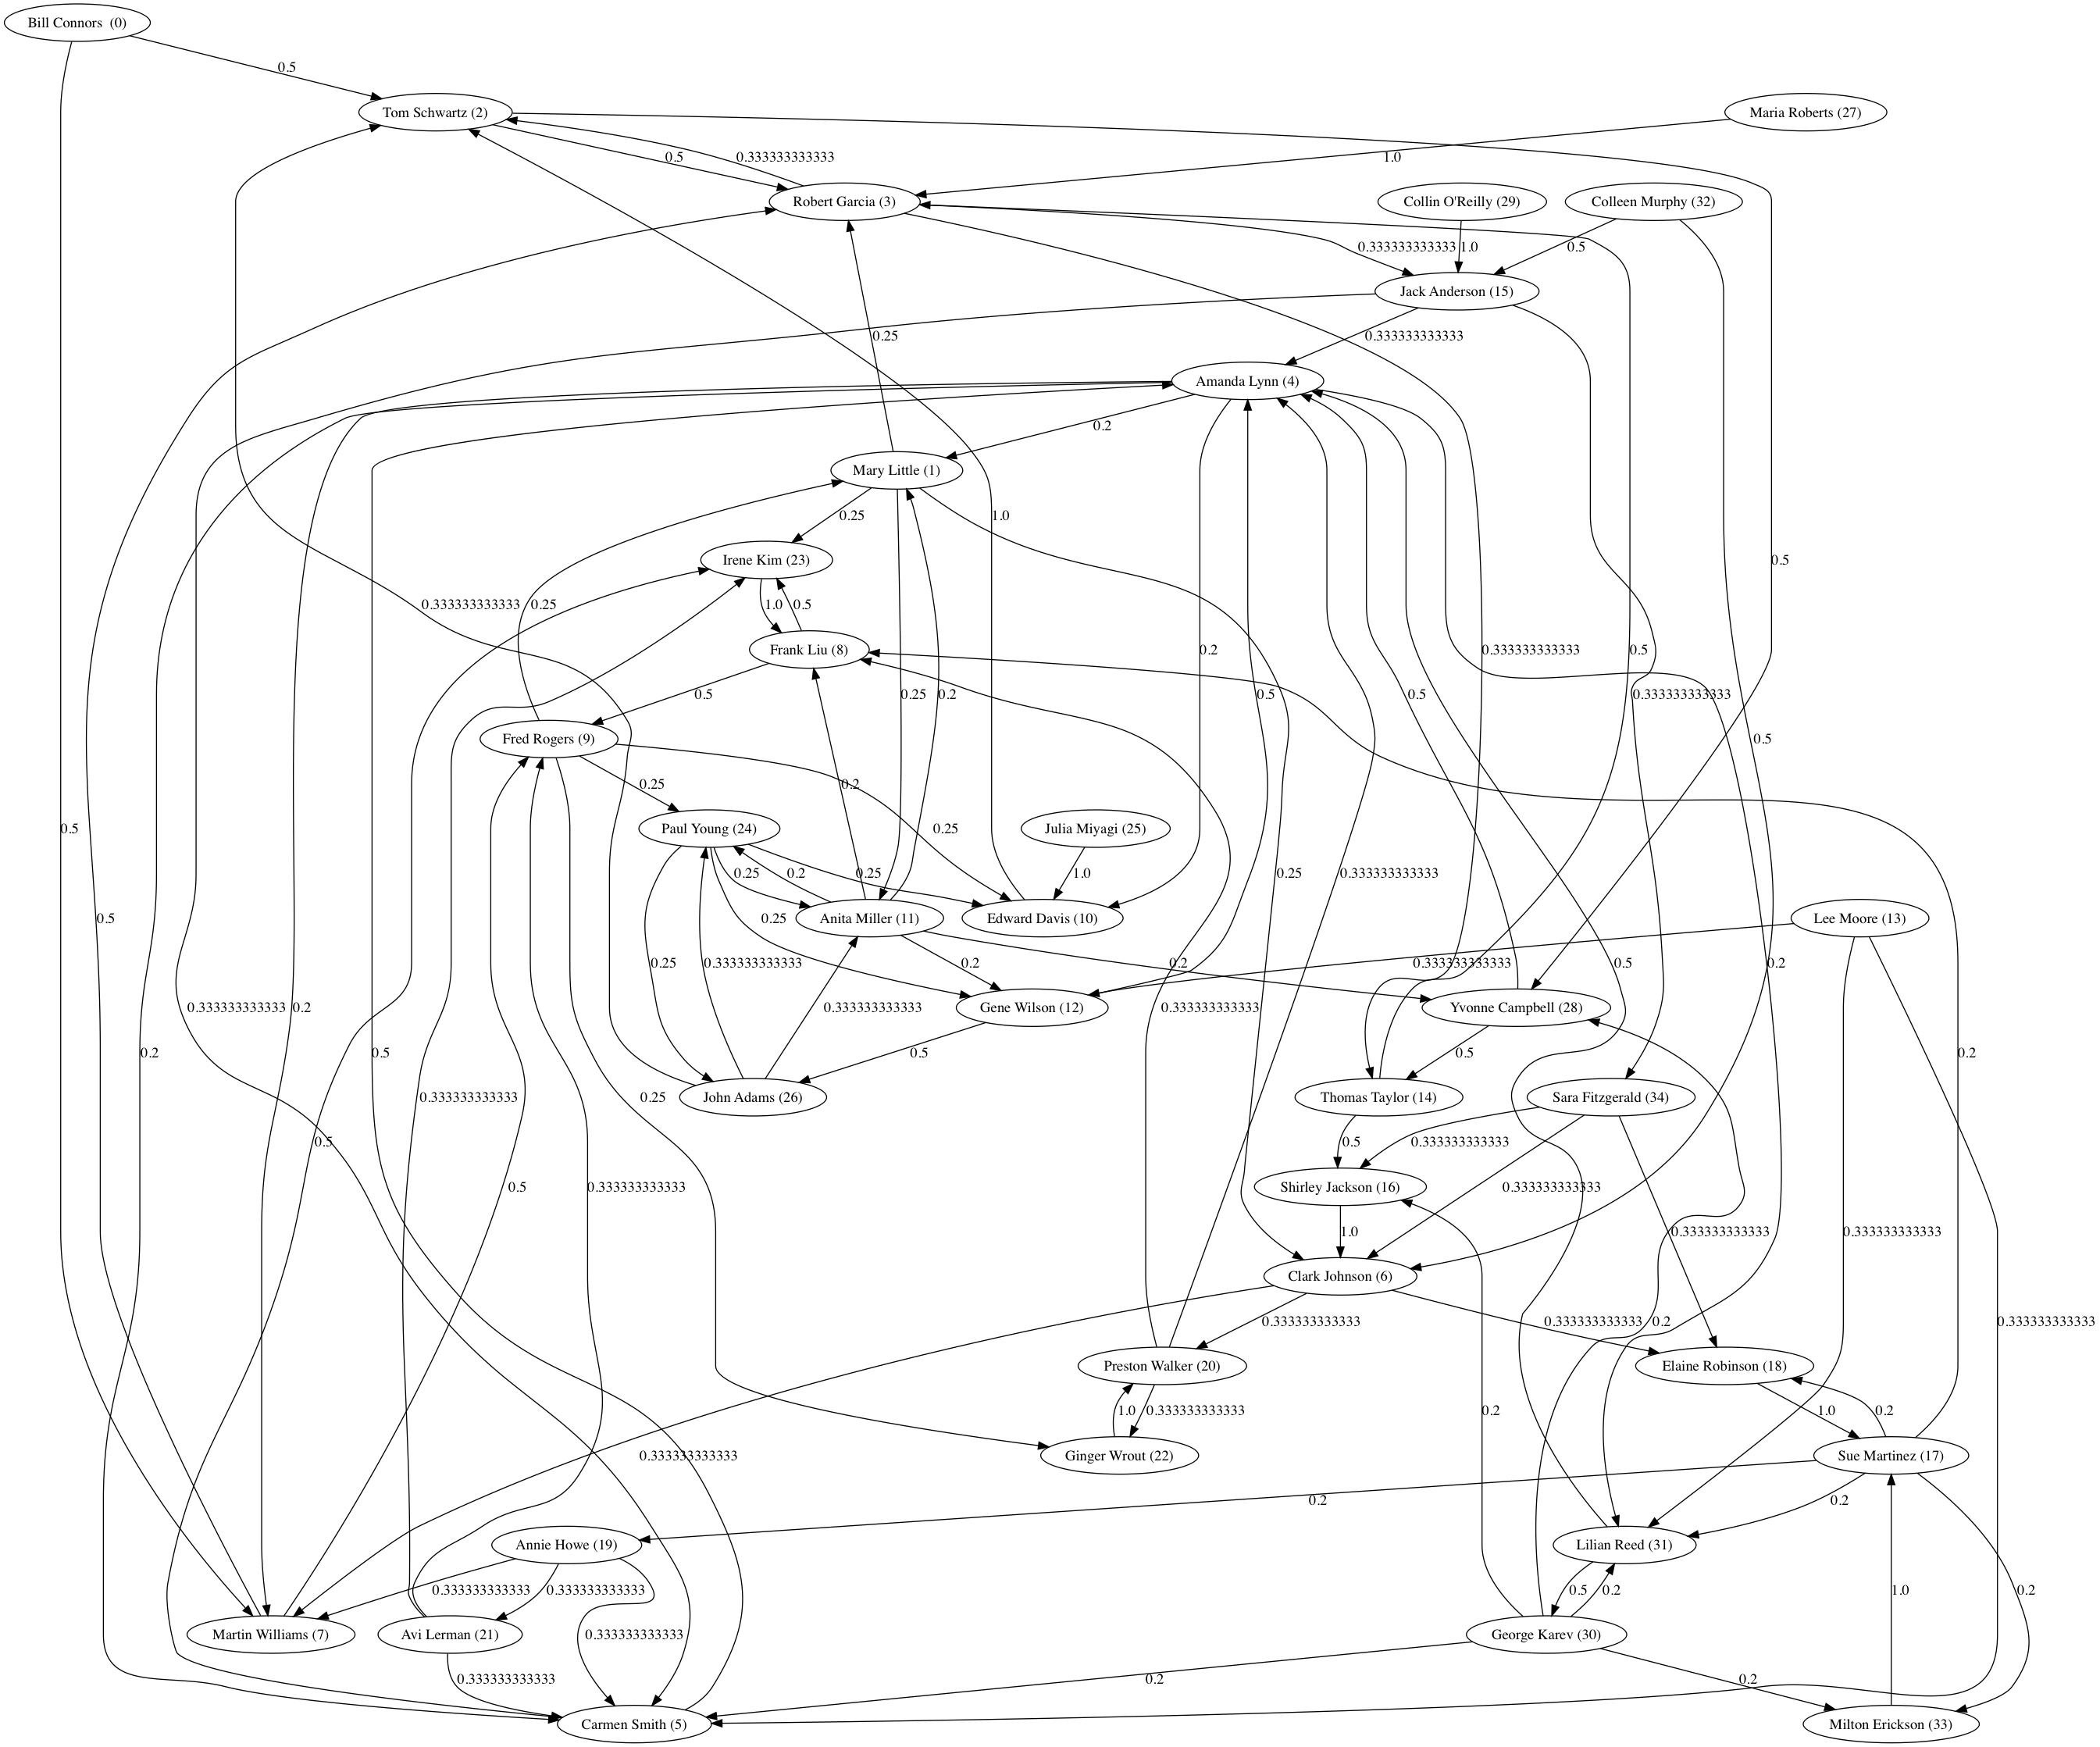

In [8]:
import pydot_ng as pydot
from IPython.display import Image 

def plot_transition_matrix(m,labels,output_file):
    graph = pydot.Dot(graph_type='digraph')
    n = m.shape[0]
    nodes = dict()
    for i in range(n):
        nodes[i]=pydot.Node(labels[i] + ' (' + str(i) + ')')
        graph.add_node(nodes[i])
    for i in range(n):
        for j in range(n):
            if m[i,j]>0:
                graph.add_edge(pydot.Edge(nodes[i], nodes[j],label=str(m[i,j])))
    graph.write_png(output_file) 
    
plot_transition_matrix(numpyMatrix,labels=vote.Members,output_file='temp.png')
Image('temp.png')

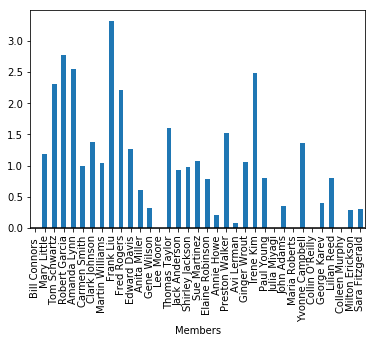

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

# Rank the candidates (display the result of PageRank).
rank = pd.DataFrame(data=result, columns= vote.Members)
names = rank.columns
names
rank.iloc[48,:].plot(kind='bar'); plt.axhline(0, color='k')



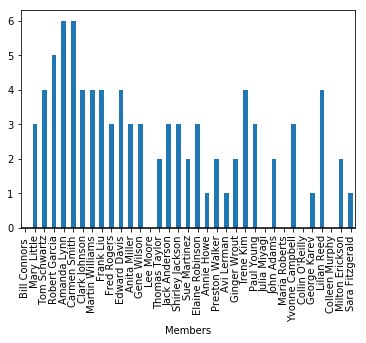

In [67]:
# Rank the candidates based on the total number of votes each candidate received.
votes_count = np.zeros((x))
votes_count = Series(votes_count, index=vote.Members)
votes_count.loc[vote.Members.iloc[0]]



for i in range(0,len(vote)):
    count = 5-vote.iloc[i,].isnull().sum()
    for j in range(1,count+1):
        votes_count.loc[vote.iloc[i,j]] = votes_count.loc[vote.iloc[i,j]]+1
        
votes_count.plot(kind='bar'); plt.axhline(0, color='k')

# Optional coding assignment
This is an __optional__ exercise, which will be graded and counted towards the class participation component of your grade (it could only improve your grade).

Read the first chapter in https://automatetheboringstuff.com/chapter3/ and solve the practice quetsions appearing at the end of the chapter.

In [ ]:
# Solution to Q1
# A major advantage of functions is to group code that gets executed multiple times. 
# Without a function defined, we would have to copy and paste many times 

In [ ]:
# Solution to Q2
# The function is executed when the function is called, not when the function is first defined.

In [ ]:
# Solution to Q3
# def statement

In [ ]:
# Solution to Q4
# In code, a function call is just the function’s name followed by parentheses, possibly with some number of arguments
#in between the parentheses. When the program execution reaches these calls, it will jump to the top line in the 
#function and begin executing the code there. When it reaches the end of the function, the execution returns to the 
#line that called the function and continues moving through the code as before.

In [ ]:
# Solution to Q5
# 1 global scope and many local scope
#

In [ ]:
# Solution to Q6
# In general, the value that a function call evaluates to is called the return value of the function.
# Yes

In [ ]:
# Solution to Q7
# In general, the value that a function call evaluates to is called the return value of the function.
# Yes

In [ ]:
# Solution to Q8
# None value

In [ ]:
# Solution to Q9
# Use global statement

In [ ]:
# Solution to Q10
# None type datatype

In [ ]:
# Solution to Q11
# import the module areallyourpetsnamederic

In [ ]:
# Solution to Q12
# spam.bacon()

In [ ]:
# Solution to Q13
# try and exception statement

In [ ]:
# Solution to Q14
# The code that could potentially have an error is put in a try clause. The program execution moves to the start of a
# following except clause if an error happens.

In [77]:
# Solution to practice project: The Collatz Sequence
def Collatz(a):
    a = int(a)
    print(int(a))
    if(a == 1):
        return 1
    elif (a%2 == 0):
        return Collatz(a/2)
    else:
        return Collatz(3*a+1)
    
var = input("Please enter something: ")
Collatz(var)

Please enter something: 3
3
10
5
16
8
4
2
1


1

In [94]:
# Solution to practice project: Input Validation
def Collatz(a):
    try:
        a = int(a)
        print(int(a))
        if(a == 1):
            return 1
        elif (a%2 == 0):
            return Collatz(a/2)
        else:
            return Collatz(3*a+1)
    except ValueError:
        print('This is not an integer')
        var = input("Please enter an interger: ")
        return Collatz(var)
    
    
var = input("Please enter an interger: ")
Collatz(var)

Please enter an interger: s
This is not an integer
Please enter an interger: 5
5
16
8
4
2
1


1